# Assignment 1 — Lars van den Heuvel  
### *Exploring Real-World Networks*

---

**Course:** Model Based Decisions (2025) — *MSc Complex Systems & Policy*  
**Lecturer:** Michael Lees  

---

**Datacollectors & Credits:**  
>J. Leskovec, D. Huttenlocher, J. Kleinberg. *Signed Networks in Social Media.* CHI 2010.  
>J. Leskovec, D. Huttenlocher, J. Kleinberg. *Predicting Positive and Negative Links in Online Social Networks.* WWW 2010.

>Link to website:https://snap.stanford.edu/data/wiki-Vote.html



In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gzip
def load_adminship_data(filepath):
    print("Loading Wikipedia adminship election data...")
#making a dictionary to link usernames to nodes
    edges = []
    id_to_username = {}
    current_candidate = None
    current_candidate_name = None

#needed to parse through the candidates U, nominators N, and voters V in this way since the build up of the dataset
    with gzip.open(filepath, 'rt', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue

            parts = line.split('\t')

            if parts[0] == 'U' and len(parts) >= 3:
                current_candidate = parts[1]
                current_candidate_name = parts[2]
                id_to_username[current_candidate] = current_candidate_name

            elif parts[0] == 'N' and len(parts) >= 3:
                nom_id = parts[1]
                nom_name = parts[2]
                id_to_username[nom_id] = nom_name

            elif parts[0] == 'V' and current_candidate and len(parts) >= 5:
                vote = int(parts[1])
                voter_id = parts[2]
                voter_name = parts[4]
                id_to_username[voter_id] = voter_name
                edges.append((voter_id, current_candidate, {'vote': vote}))

    print(f"Parsed {len(edges)} edges.")
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # usernames for semantic meaning later on (previously had Node2545 for example)
    for node_id, name in id_to_username.items():
        if node_id in G:
            G.nodes[node_id]['username'] = name

    print(f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G, id_to_username




In [48]:
# -------------------------------------------------------------
# Compute summary statistics
# -------------------------------------------------------------
def network_summary(G):
    print("\n" + "="*60)
    print("NETWORK SUMMARY")
    print("="*60)

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Directed: {G.is_directed()}")

    # Largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(largest_cc).copy()
    print(f"Largest component: {Gcc.number_of_nodes()} nodes, {Gcc.number_of_edges()} edges")

    density = nx.density(Gcc)
    clustering = nx.average_clustering(Gcc.to_undirected())
    assort = nx.degree_assortativity_coefficient(Gcc.to_undirected())
    print(f"Density: {density:.6f}")
    print(f"Average clustering coefficient: {clustering:.4f}")
    print(f"Assortativity: {assort:.3f}")

    try:
        apl = nx.average_shortest_path_length(Gcc.to_undirected())
        print(f"Average shortest path length: {apl:.2f}")
    except Exception as e:
        print(f"Could not compute path length: {e}")

In [49]:
# -------------------------------------------------------------
# Degree distribution
# -------------------------------------------------------------
def plot_degree_distribution(G):
    print("Plotting degree distribution...")
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = Counter(degrees)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.bar(degree_counts.keys(), degree_counts.values(), color='skyblue', edgecolor='black')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("Degree Distribution (Linear)")
    
    #changing the axis form the notebook to increase visualization of plot
    plt.xlim(0, 300)       
    plt.ylim(0, 2000)      

    plt.subplot(1,2,2)
    plt.loglog(list(degree_counts.keys()), list(degree_counts.values()), 'bo', alpha=0.7)
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.title("Degree Distribution (Log-Log)")

    plt.tight_layout()
    plt.show()

    print(f"Mean degree: {np.mean(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")


In [50]:
#----- --------------------------------------------------------
# Centrality measures
# -------------------------------------------------------------
def calculate_centrality_measures(G):
    print("\nCalculating centrality measures...")
    centralities = {}

    # Convert to largest component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    Gcc = G.subgraph(largest_cc).copy()

# sampling for betweeenness like suggested in class, I took 1000 like mentioned 
    centralities['degree'] = nx.degree_centrality(Gcc)
    centralities['betweenness'] = nx.betweenness_centrality(Gcc, k=1000)  
    centralities['closeness'] = nx.closeness_centrality(Gcc)
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(Gcc.to_undirected(), max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("Eigenvector centrality failed to converge; using PageRank instead")
        centralities['eigenvector'] = nx.pagerank(Gcc)

    return centralities

def display_top_nodes(centralities, id_to_username, top_n=10):
    print("\n" + "="*60)
    print(f"TOP {top_n} USERS BY CENTRALITY")
    print("="*60)
    for measure, values in centralities.items():
        top_nodes = sorted(values.items(), key=lambda x: x[1], reverse=True)[:top_n]
        print(f"\n{measure.upper()} CENTRALITY")
        print("-"*40)
        for i, (node, val) in enumerate(top_nodes, 1):
            username = id_to_username.get(node, f"Node {node}")
            print(f"{i:2d}. {username} (ID {node}) - {val:.6f}")

In [51]:
#the three classical models retrieved and adapted from the network_visualization_suite.py 

def compare_with_models(graph):
    models = {
        "Random": nx.erdos_renyi_graph,
        "Small-World": nx.watts_strogatz_graph,
        "Scale-Free": nx.barabasi_albert_graph
    }
#here I print a table for results per model
    print("Network\t\tClustering\tPath Length")
    print("-----------------------------------------")

#loop through the models for the parameters generating the networks
    for name, model_func in models.items():

        n = graph.number_of_nodes()
        if name == "Random":
            m = graph.number_of_edges()
            p = 2 * m / (n * (n - 1))
            G_model = model_func(n, p)
        elif name == "Small-World":
            k = int(sum(dict(graph.degree()).values()) / n)
            # why did they put it 0.1?
            G_model = model_func(n, k, 0.1)
            #Else in this case will compute the Scale-Free / barabasi model
        else: 
            # Bereken het aantal kanten dat wordt toegevoegd bij elke stap (m)
            # Dit is ruwweg de helft van de gemiddelde degree
            m = int(sum(dict(graph.degree()).values()) / (2 * n))
            G_model = model_func(n, m)
        
        # since some models have disconnected nodes so if that happens, we will take the largest connected component (else)
        G_model_undirected = G_model.to_undirected()
        
        if nx.is_connected(G_model_undirected):
            L = nx.average_shortest_path_length(G_model_undirected)
        else: 
            largest_cc = max(nx.connected_components(G_model_undirected), key=len)
            subgraph = G_model_undirected.subgraph(largest_cc)
            L = nx.average_shortest_path_length(subgraph)
        
        C = nx.average_clustering(G_model)
        print(f"{name:8s}\t{C:.4f}\t\t{L:.2f}")

        # Adds the degree distrubution for the three models
        degrees = [d for n, d in G_model.degree()]
        plt.figure()
        plt.hist(degrees, bins=range(min(degrees), max(degrees)+2), edgecolor='black', align='left')
        plt.title(f"Degree Distribution: {name}")
        plt.xlabel("Degree")
        plt.ylabel("Number of Nodes")
        plt.show()



Loading Wikipedia adminship election data...
Parsed 114040 edges.
Loaded network with 7194 nodes and 110087 edges.

NETWORK SUMMARY
Number of nodes: 7194
Number of edges: 110087
Directed: True
Largest component: 7136 nodes, 110053 edges
Density: 0.002161
Average clustering coefficient: 0.1484
Assortativity: -0.087
Average shortest path length: 3.23
Plotting degree distribution...


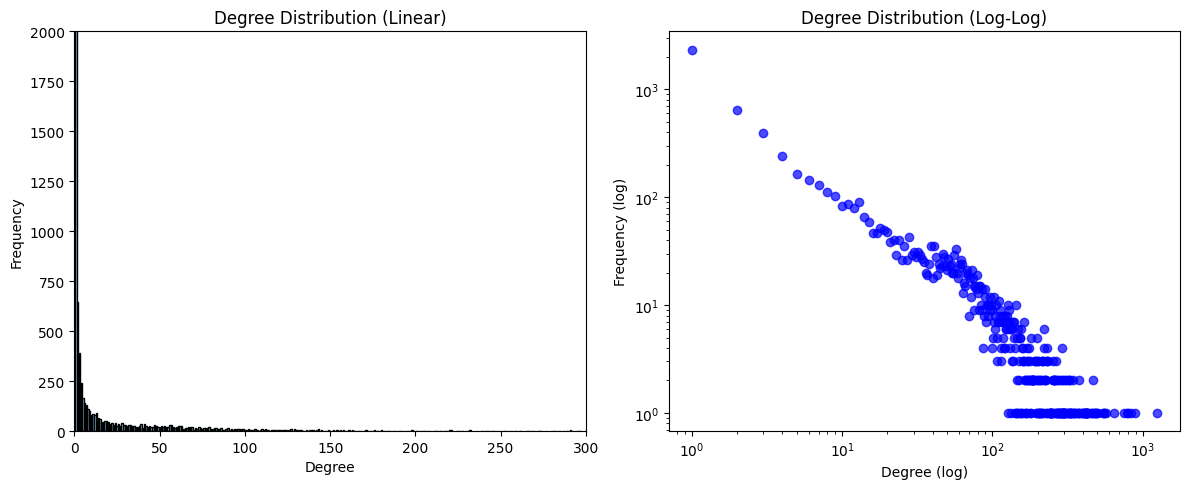

Mean degree: 30.61
Max degree: 1243

Calculating centrality measures...

TOP 10 USERS BY CENTRALITY

DEGREE CENTRALITY
----------------------------------------
 1. siva1979 (ID 2565) - 0.174212
 2. jaranda (ID 1549) - 0.123896
 3. mailer (ID 766) - 0.117169
 4. merovingian (ID 11) - 0.112404
 5. the (ID 457) - 0.110722
 6. xoloz (ID 1166) - 0.105676
 7. terence (ID 2688) - 0.091100
 8. neil (ID 1374) - 0.080168
 9. mongo (ID 1151) - 0.078206
10. acalamari (ID 5524) - 0.077085

BETWEENNESS CENTRALITY
----------------------------------------
 1. siva1979 (ID 2565) - 0.019733
 2. jaranda (ID 1549) - 0.017238
 3. danny (ID 15) - 0.010727
 4. everyking (ID 72) - 0.008901
 5. daniel (ID 737) - 0.005910
 6. phaedriel (ID 2328) - 0.005740
 7. xoloz (ID 1166) - 0.005403
 8. majorly (ID 5079) - 0.005208
 9. khoikhoi (ID 2237) - 0.005119
10. bd2412 (ID 993) - 0.004719

CLOSENESS CENTRALITY
----------------------------------------
 1. elonka (ID 4037) - 0.301534
 2. danny (ID 15) - 0.295761
 3. we

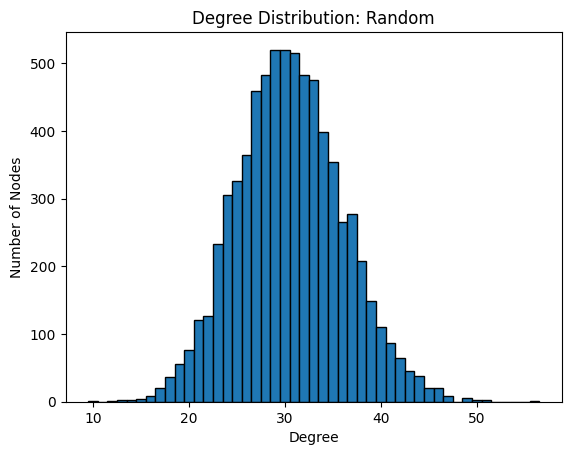

Small-World	0.5287		3.61


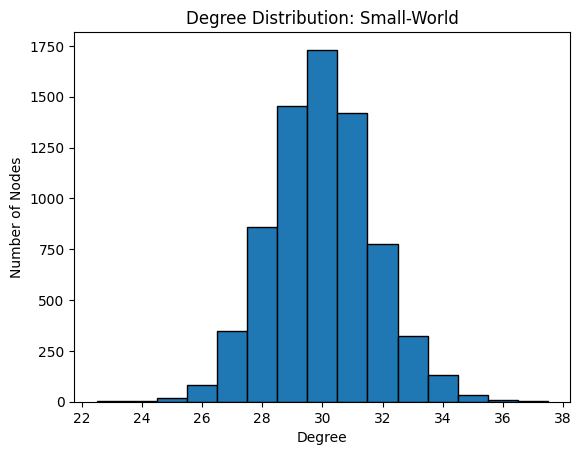

Scale-Free	0.0182		2.80


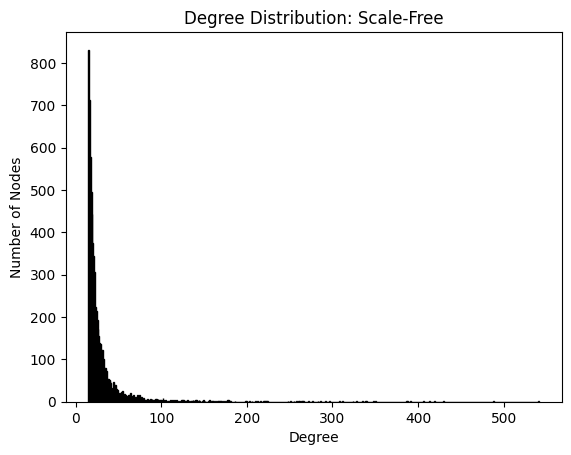

In [52]:
def main():
    file = "C:/Users/lars_/MBDM/Week 2 - Networks/datasets/wikiElec.ElecBs3.txt.gz"
    G, id_to_username = load_adminship_data(file)
    network_summary(G)
    plot_degree_distribution(G)
    centr = calculate_centrality_measures(G)
    display_top_nodes(centr, id_to_username)
    compare_with_models(G)

if __name__ == "__main__":
    main()
